# Applying GrandPrix on single-cell qPCR data of early developmental stages in mouse
_Sumon Ahmed_, 2017

This notebooks describes the flexible architecture of the GrandPrix by extending it to 2-D latent spaces. Models with both informative and non-informative priors are examined.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from GrandPrix import GrandPrix
from utils import plotcorrelation, plot_XY
%matplotlib inline

## Data description

<a href="https://www.ncbi.nlm.nih.gov/pubmed/20412781" target="_blank">Guo et al. (2010)</a> generated gene expression profiles of 48 genes measured across 437 cells. Cells differentiate from the single cell stage into three different cell states in the 64 cell stage: trophectoderm (TE), epiblast (EPI), and primitive endoderm (PE).

The "GuoTrainingData.csv" file contains the expression profiles of this dataset.

In [2]:
Y = pd.read_csv('data/Guo/GuoTrainingData.csv', index_col=[0])

In [3]:
N, D = Y.shape

## Model Construction
The first step of using the GrandPrix is to initialize the model with the observed data

In [4]:
guo = GrandPrix(Y.values)

### Build sparse Bayesian GPLVM model
Following initializations are essential for better optimizations. If not initialized, the default values will be used.  
<ul>
<li>__kernel:__ Covariance function to define the mappring mapping from the latent space to the data space in Gaussian process prior. 
<!--
    <ul>
        <li>name</li>
        <li>ls</li>
        <li>var</li>
        <li>period</li>
    </ul>
-->
</li>

<li>__vParams:__ Variational Parameters
    <ul>
        <li>Xmean - mean of the latent dimensions. 
        
        ndarray of size $N \times Q$.</li>
        <li>Xvar - variance over the latent dimensions. A single floating point value or a ndarray of size $N \times Q$.</li>
        <li>Z - inducing inputs. ndarray of size $M \times Q$.</li>
    </ul>
</li>
<li>__priors:__ Prior over the latent input dimensions
    <ul>
        <li>Priormean - mean of the prior distribution. ndarray of size $N \times D$.</li>
        <li>Priorvar - variance of the prior distribution. A floating point value or a ndarray of size $N \times D$.</li>
    </ul>
</li>

<li>__latent_dims:__ Number of latent dimensions. An integer.</li>
<li>__n_inducing_points:__ Number of inducing points. An integer.</li>
</ul>

In [5]:
latent_dims = 2
n_inducing_points = 40
X_var = 0.028
vParams = {'Xvar':X_var}

## Without informative prior

In [6]:
guo.build_model(vParams=vParams, latent_dims=latent_dims, n_inducing_points = n_inducing_points)

In [7]:
guo.fit_model()

- `get_latent_dims` returns the specified number of latent dimensions.

In [8]:
X_np = guo.get_latent_dims(2)

## With informative prior

In [9]:
def MapTo01(y):
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))
ct = np.zeros(N)
for il, l in enumerate(Y.index):
    s = l.split(' ')
    ct[il] = int(s[0])
prior_mean = np.zeros((N, latent_dims))
prior_mean[:, 0] = MapTo01(ct) 

priors = {'Priormean':prior_mean, 'Priorvar':0.1}

In [10]:
guo.build_model(priors, vParams, latent_dims=latent_dims, n_inducing_points = n_inducing_points)

In [11]:
guo.fit_model()

In [12]:
X_wp = guo.get_latent_dims(2)

# Visualize the results
The informative prior on capture time helps with the identifiability of the model as it aligns the first latent dimension (horizontal axis) with pseudotime and the second latent dimension (vertical axis) with the branching structure.

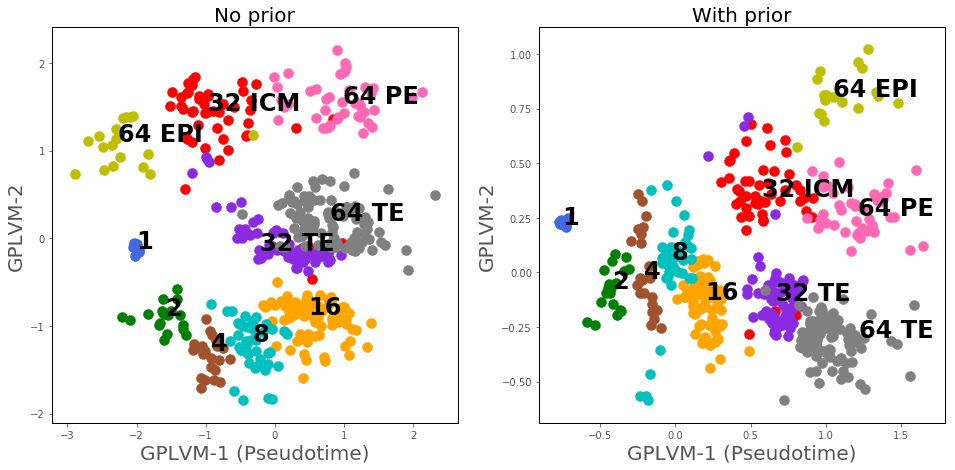

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plot_XY(X_np[:,0], X_np[:,1], 'No prior', Y.index)
plt.subplot(2, 2, 2)
plot_XY(X_wp[:,0], X_wp[:,1], 'With prior', Y.index)

## 1-D optimization
The 1-D pseudotime model with informative prior.

In [14]:
x = prior_mean[:,0][:,None]
p = {'Priormean':x, 'Priorvar':0.1}
vParams = {'Xvar':X_var}
guo.build_model(p, vParams=vParams, latent_dims=1, n_inducing_points = 30)

In [15]:
guo.fit_model()

In [16]:
X_1d_opt = guo.get_latent_dims(1)

## Comparison to the actual capture time
The 2-D model estimate of the pseudotime is found to have better correspondence with the actual capture time (correlation 0.84 vs 0.95), suggesting that the 1-D model is less able to align all variation with a pseudotime axis.

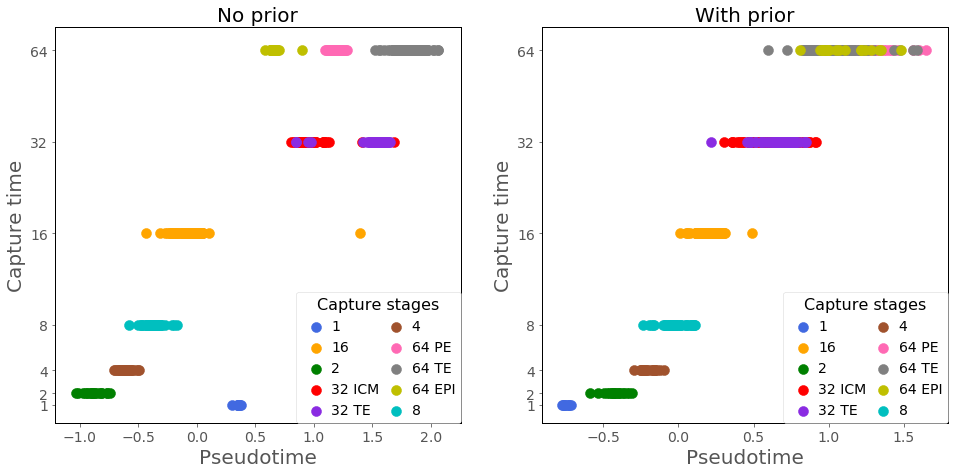

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plotcorrelation(X_1d_opt[:, 0], ct, 'No prior', Y.index)
plt.subplot(2, 2, 2)
plotcorrelation(X_wp[:, 0], ct, 'With prior', Y.index)

## Plot marker genes
* _Id2_ - a known marker gene for TE, thus it behaves differently in TE cells from the other two differentiation stages.
* _Gata4_ - Gata4 is differentially expressed between the stages (PE and EPI) and between the stages (TE and PE).

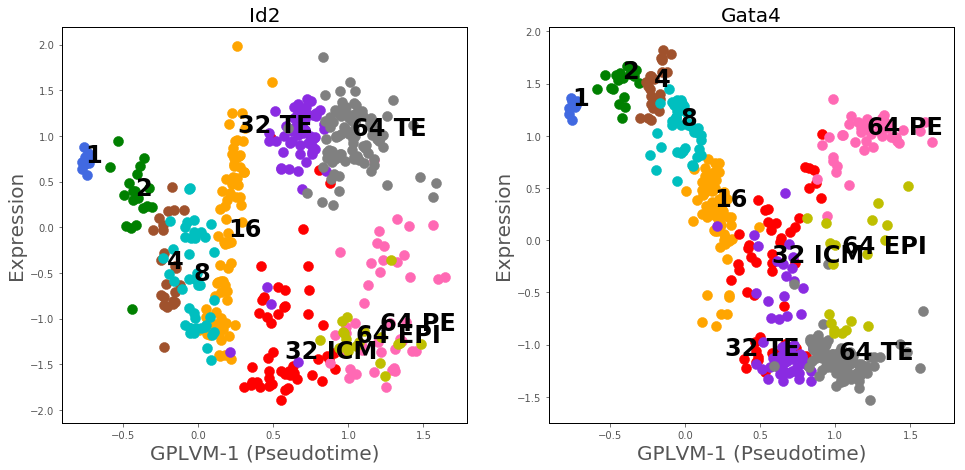

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plot_XY(X_wp[:,0], -Y['Id2'], 'Id2', Y.index, ylabel='Expression')
plt.subplot(2, 2, 2)
plot_XY(X_wp[:,0], -Y['Gata4'], 'Gata4', Y.index, ylabel='Expression')